In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from src.env.DunderBotEnv import DunderBotEnv
import src.run as run
import src.load as load
import src.preprocess as preprocess
import src.data_raw as data_raw
from src.util.run_util import create_timedelta_and_plot

from src.util.config import get_config
config = get_config()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

loading config from config/config.yml


# TODO:

- Optimize other rewards
- Add check for NaNs after head:ing with number of NaNs from config. Include infs. Abort if any.
    * Check if there are any NaNs for 1m data.
- Improve data copy when building Docker cotainer
- Choose best exchange to use for now (data up til today)
- Consider ffill nan handling for TI:s (and likely dropping the filled data after)
- Consider this as two separate points for MLP and LSTM. Different requirements (see other point)
- Check/Enable/Add exploration noise (for PPO2, use the entropy flag), use https://stable-baselines.readthedocs.io/en/master/common/schedules.html. Will need to assess if model is still unstable.
- setup performance output, what we need to make data driven decision
    *e.g. https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/1_getting_started.ipynb#scrollTo=63M8mSKR-6Zt. Some Medium articles uses Sharpe values, investigate.
- Download and enable order book data (how do you aggregate orders in time bins?)
- Experiment with orders as features
    * e.g. shape of order book etc.
- self.stationarize_rewards?
- Set good period for ti features
- Test other TI packages for better efficiency
- Revisit technical features
- Test additional models to PPO2. Be careful though, many require different setting in which to run optimally.
- Hyperparameter search
- Optimize to save some time every iteration
- Explore different gamma (Discount factor)
- Correct for displaced index due to specified TI NaNs
- Checkout frame stacking as a poor man's lstm (unlikely that it's useful, since we're dealing with time series)
- Get the available LSTM networks working and compare with MLP (tips: https://github.com/hill-a/stable-baselines/issues/646). NOTE: LSTMs also need state during prediction as well as proper env counts for train and test (https://github.com/hill-a/stable-baselines/issues/166 and https://stable-baselines.readthedocs.io/en/master/guide/examples.html#recurrent-policies). Also: https://github.com/hill-a/stable-baselines/issues/308
- Understand more advanced custom policy networks better (need to understand terminology surronding it, e.g. environment, n_steps etc). See also discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759, https://github.com/hill-a/stable-baselines/issues/278, https://github.com/hill-a/stable-baselines/issues/646)
- understand the rendering during learning (prob need to read the code to understand all callback fields)
- untangle index weirdness (basically, try to enable prediction the last timestep, and make running interface easier (and more robust))
    * Check info box for reason and solution: https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html
    * This might also help (at the end) https://github.com/hill-a/stable-baselines/issues/779
- Check float number type



# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (still Discrete, I believe)
- wrap running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Add commission and slippage
- Refactor current reward and add some new ones
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add portfolio features
- Add reward output
- setup train/test functionality
- Enable saving/loading trained models
- Normalize observations
- Add env checker (disbled by default, but passed)
- lock down the seeds
- Add finer temporal resolution in data (minute granularity)
- Add support for higher frequency data: NaN handling and pushed starting timestamp
- Add technical indicator features
- Add benchmarks
- Add dynamic data download and preparation by downloading all transactions -> render OHLC in multiple time granularities
- Add full support for multiprocessing
- Suppress tensorflow warnings
- Substantial time optimizations to avoid growing time per iteration of training
- Substantial memory savings from only saving data we need during training
- Added flag to refresh data


# Run

In [2]:
%%time
data_raw.download_and_process(force_refresh=False)
df = load.load_OHLC_data()
df = preprocess.preprocess_data(df=df)
config.n_cpu=8
env = run.setup_env(df=df)

Will download and process raw data, since data specified in config is not available or refresh requested
Bitstamp_USD.csv.gz downloaded and saved to ./data/raw

Unpacking and loading raw data file...
Done.

Preparing the raw data...
Done.
Processed data file saved in .data/input/.
LOAD: Loading data with 3283 samples
PREPROCESS: Dropping 0 NaNs out of 3283 samples (0.0%) from input file
PREPROCESS: Dropping unused data, 3283 -> 2010 samples
PREPROCESS: Adding technical features...
Done.
Setting up environment using 8 cores...
Resetting to timesteps: start 1419, end 2282.
Done.
CPU times: user 7min 55s, sys: 31.4 s, total: 8min 26s
Wall time: 9min 16s


In [5]:
%%time
past = datetime.now()
model = run.train(env=env, logging=True)
#print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/config.train_predict.train_timesteps}')
#print(f'Avg time per total timestep: {(datetime.now()-past).total_seconds()/config.train_predict.train_timesteps/config.n_cpu}')
#create_timedelta_and_plot(model=model)

RUN: Training for 1000 serial timesteps and 8000 total timesteps...
RUN: Saving files to /tmp/
Done.
CPU times: user 4.04 s, sys: 1.06 s, total: 5.1 s
Wall time: 6.32 s


RUN: Loading files from /tmp/
RUN: Model connected with env
RUN: Predicting for 989 timesteps
Resetting to timesteps: start 17574630, end 17575620.
Rendering TradingChartStatic for index steps 17574630 through 17575619
Not rendering trades since they are too many to distinguish in plot (989)


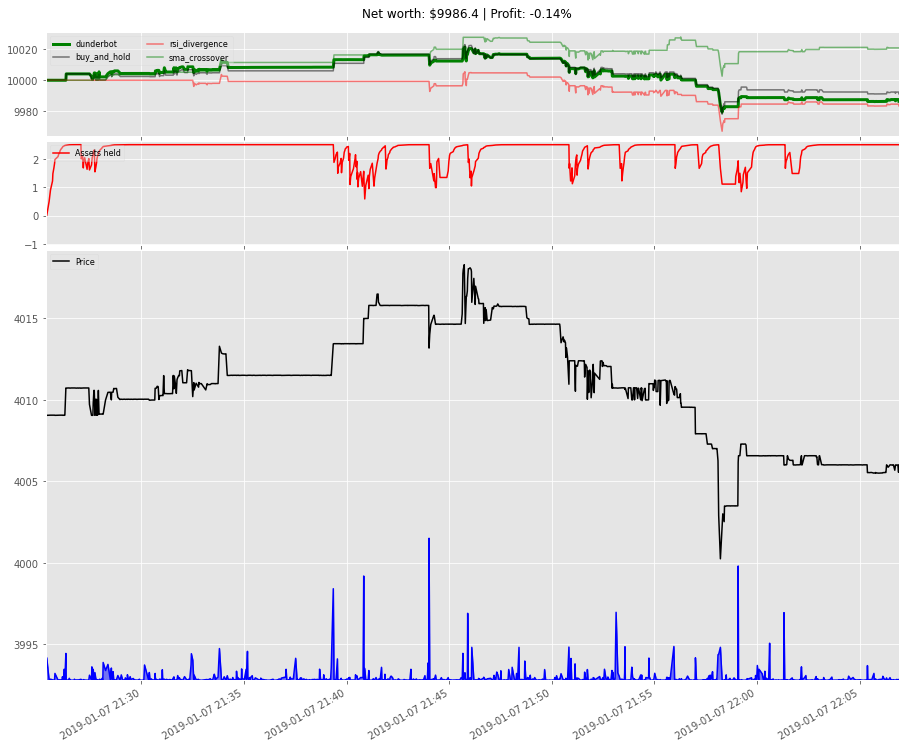

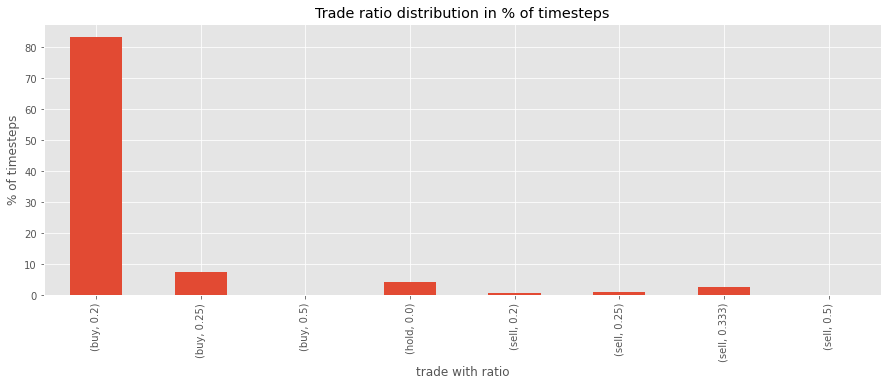

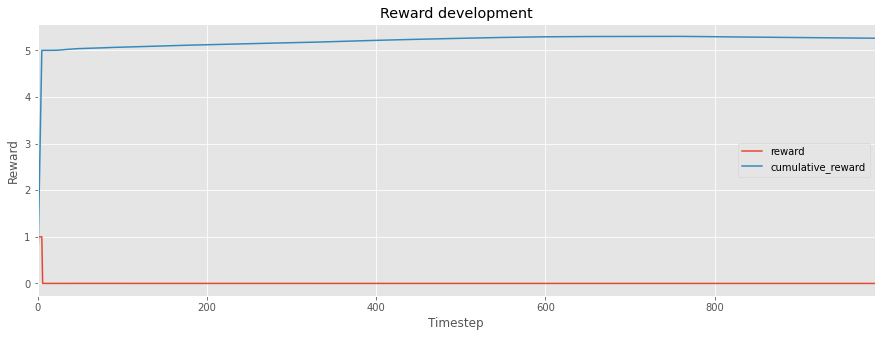

CPU times: user 6.05 s, sys: 695 ms, total: 6.74 s
Wall time: 5.96 s


In [4]:
%%time
run.predict(df=df, rendermode='plots')

In [6]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 18,
 'net_worths': [10000.0,
  10000.0,
  10000.0,
  10001.7,
  9993.31,
  9845.08,
  9818.83,
  9857.64,
  9811.18,
  9826.9,
  9849.13,
  9841.65,
  9846.6,
  9906.72,
  9857.82,
  9825.55,
  9844.28,
  9835.73,
  9843.79,
  9853.91,
  9847.28,
  9858.84,
  9884.08,
  9846.62,
  9846.11,
  9859.04,
  9865.74,
  9849.82,
  9871.96,
  9886.04,
  9852.41,
  9828.36,
  9781.67,
  9796.26,
  9789.61,
  9787.16,
  9798.66,
  9821.71,
  9819.04,
  9825.21,
  9813.02,
  9817.28,
  9809.9,
  9810.35,
  9815.73,
  9852.16,
  9844.47,
  9845.15,
  9833.28,
  9836.58,
  9863.32,
  9843.26,
  9846.9,
  9838.6,
  9843.73,
  9840.44,
  9971.54,
  9981.18,
  9980.54,
  9981.68,
  9980.22,
  9984.06,
  10005.04,
  9992.58,
  9998.53,
  10012.4,
  10006.93,
  9995.75,
  9951.78,
  9922.8,
  9824.37,
  9840.96,
  9803.94,
  9764.1,
  9780.03,
  9798.29,
  9787.19,
  9793.24,
  9805.33,
  9789.97,
  9796.14,
  9795.5,
  9814.97,
  9812.16,
  9803.83,
  9817.89,
  9804.12,
  9807.79,
  9

In [8]:
x.keys()

dict_keys(['current_step', 'net_worths', 'trades', 'account_history', 'rewards'])